In [1]:
from tensorflow.keras.layers import Layer, Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [2]:
class Up(Layer):
    def __init__(self, filters, dropout_rate, kernel_size, batchnorm):
        super(Up, self).__init__()
        self.trans_conv = Conv2DTranspose(filters, kernel_size, strides = (2, 2), padding = 'same')
        self.dropout = Dropout(dropout_rate)
        self.double_conv = DoubleConv2D(filters, kernel_size, batchnorm)

    def call(self, VerticalConvInput, list_HorizontalConvInput):
        x = self.trans_conv(VerticalConvInput)
        x = Concatenate()([x]+list_HorizontalConvInput)
        x = self.dropout(x)
        VerticalConvOutput = self.double_conv(x)

        return VerticalConvOutput

class Down(Layer):

    def __init__(self, filters, kernel_size, dropout_rate, batchnorm):
        super(Down, self).__init__()
        self.double_conv = DoubleConv2D(filters, kernel_size, batchnorm)
        self.maxpool = MaxPool2D((2, 2))
        self.dropout = Dropout(dropout_rate)
    
    def call(self, input_tensor):
        conv_output = self.double_conv(input_tensor)
        pool_output = self.maxpool(conv_output)
        pool_output = self.dropout(pool_output)

        return conv_output, pool_output
    
class DoubleConv2D(Layer):

    def __init__(self, filters, kernel_size, batchnorm):
        super(DoubleConv2D, self).__init__()
        self.conv1 = Conv2D(filters = filters, kernel_size = kernel_size, kernel_initializer = 'he_normal', padding = 'same')
        self.conv2 = Conv2D(filters = filters, kernel_size = kernel_size, kernel_initializer = 'he_normal', padding = 'same')
        self.batchnorm = batchnorm

    def call(self, input_tensor):    
        x = self.conv1(input_tensor)
        #if self.batchnorm : x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = self.conv2(x)
        #if self.batchnorm : x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

class Supervision(Layer):

    def __init__(self, deep):
        super(Supervision, self).__init__()
        self.deep = deep
        if deep:
            self.list_Conv2D = []
            for i in range(4):
                self.list_Conv2D.append(Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same'))
        else:
            self.Conv2D = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same')
    
    def call(self, list_SegmentationBranches):
        if self.deep:
            return [self.list_Conv2D[i](list_SegmentationBranches[i]) for i in range(len(list_SegmentationBranches))]
        else:
            return self.Conv2D(list_SegmentationBranches[0])
        

In [3]:
class NestedUNet(Model):

    def __init__(self, n_filters, dropout_rate, deep, batchnorm):

        super(NestedUNet, self).__init__()

        self.Border_Down_0 = Down(filters = n_filters * 1, kernel_size = 2, dropout_rate = dropout_rate, batchnorm = batchnorm)
        self.Border_Down_1 = Down(filters = n_filters * 2, kernel_size = 2, dropout_rate = dropout_rate, batchnorm = batchnorm)
        self.Border_Down_2 = Down(filters = n_filters * 4, kernel_size = 2, dropout_rate = dropout_rate, batchnorm = batchnorm)
        self.Border_Down_3 = Down(filters = n_filters * 8, kernel_size = 2, dropout_rate = dropout_rate, batchnorm = batchnorm)

        self.Nest_0_1 = Up(filters = n_filters * 1, kernel_size = 2, dropout_rate = dropout_rate, batchnorm = batchnorm)
        self.Nest_1_1 = Up(filters = n_filters * 2, kernel_size = 2, dropout_rate = dropout_rate, batchnorm = batchnorm)
        self.Nest_0_2 = Up(filters = n_filters * 1, kernel_size = 2, dropout_rate = dropout_rate, batchnorm = batchnorm)
        self.Nest_2_1 = Up(filters = n_filters * 4, kernel_size = 2, dropout_rate = dropout_rate, batchnorm = batchnorm)
        self.Nest_1_2 = Up(filters = n_filters * 2, kernel_size = 2, dropout_rate = dropout_rate, batchnorm = batchnorm)
        self.Nest_0_3 = Up(filters = n_filters * 1, kernel_size = 2, dropout_rate = dropout_rate, batchnorm = batchnorm)
        
        self.transition_double_conv = DoubleConv2D(filters = n_filters * 16, kernel_size = 2, batchnorm = batchnorm)
        
        self.Border_Up_3 = Up(filters = n_filters * 8, kernel_size = 2, dropout_rate = dropout_rate, batchnorm = batchnorm)
        self.Border_Up_2 = Up(filters = n_filters * 4, kernel_size = 2, dropout_rate = dropout_rate, batchnorm = batchnorm)       
        self.Border_Up_1 = Up(filters = n_filters * 2, kernel_size = 2, dropout_rate = dropout_rate, batchnorm = batchnorm)
        self.Border_Up_0 = Up(filters = n_filters * 1, kernel_size = 2, dropout_rate = dropout_rate, batchnorm = batchnorm)

        self.deep = deep
        self.supervision = Supervision(deep)

    def build(self, input_shape):
        super(NestedUNet, self).build(input_shape)
    
    def call(self, inputs):

        border_down_0, pooling_0 = self.Border_Down_0(inputs)
        border_down_1, pooling_1 = self.Border_Down_1(pooling_0)
        border_down_2, pooling_2 = self.Border_Down_2(pooling_1)
        border_down_3, pooling_3 = self.Border_Down_3(pooling_2)

        nest_0_1 = self.Nest_0_1(border_down_1, [border_down_0])
        nest_1_1 = self.Nest_1_1(border_down_2, [border_down_1])
        nest_0_2 = self.Nest_0_2(nest_1_1, [border_down_0, nest_0_1])
        nest_2_1 = self.Nest_2_1(border_down_3, [border_down_2])
        nest_1_2 = self.Nest_1_2(nest_2_1, [border_down_1, nest_1_1])
        nest_0_3 = self.Nest_0_3(nest_1_2, [border_down_0, nest_0_1, nest_0_2])

        thalweg = self.transition_double_conv(pooling_3)
        
        border_up_3 = self.Border_Up_3(thalweg, [border_down_3])
        border_up_2 = self.Border_Up_2(border_up_3, [border_down_2, nest_2_1])        
        border_up_1 = self.Border_Up_1(border_up_2, [border_down_1, nest_1_1, nest_1_2])
        border_up_0 = self.Border_Up_0(border_up_1, [border_down_0, nest_0_1, nest_0_2, nest_0_3])
        
        if self.deep:
            outputs = self.supervision([nest_0_1, nest_0_2, nest_0_3, border_up_0])
        else:
            outputs = self.supervision([border_up_0])
                
        return outputs

In [14]:
nUNet = NestedUNet(16,0.05,False,False)
nUNet.build((None,256,256,3))
nUNet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
nUNet.summary()

Model: "nested_u_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
down_8 (Down)                multiple                  1248      
_________________________________________________________________
down_9 (Down)                multiple                  6208      
_________________________________________________________________
down_10 (Down)               multiple                  24704     
_________________________________________________________________
down_11 (Down)               multiple                  98560     
_________________________________________________________________
up_20 (Up)                   multiple                  5168      
_________________________________________________________________
up_21 (Up)                   multiple                  20576     
_________________________________________________________________
up_22 (Up)                   multiple               

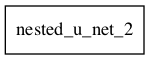

In [15]:
plot_model(nUNet, to_file='../assets/nested-unet.png', show_shapes=True, expand_nested=True)

In [16]:
import numpy as np

In [25]:
input = np.random.normal(size=(32,256,256,3))

In [26]:
nUNet(input).shape

TensorShape([32, 256, 256, 1])